In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

from statsmodels.stats import multitest 

In [2]:
exp_data = pd.read_csv('../data/tzur_hermaphrodite_data.csv', encoding='latin')
dynamic_data = pd.read_csv('../data/tzur_hermaphrodite_dynamic.csv', encoding='latin')

In [3]:
exp_data['tzur_dynamic'] = exp_data['Open reading frame'].isin(dynamic_data['Open reading frame'])

In [4]:
exp_columns = []
diff_columns = []
mean_columns = []
for num in range(1,11,1):
    col_1 = 'gonad_a' + str(num)
    exp_columns.append(col_1)
    col_2 = 'gonad_b' + str(num)
    exp_columns.append(col_2)
    exp_data['diff_'+ str(num)] = exp_data[col_1] - exp_data[col_2]
    exp_data['mean_'+ str(num)] = (exp_data[col_1] + exp_data[col_2])/2
    mean_columns.append('mean_' + str(num))
    diff_columns.append('diff_' + str(num))

In [5]:
exp_data['mean_diff'] = np.abs(exp_data[diff_columns]).mean(axis=1)
exp_data['mean_exp'] = exp_data[exp_columns].mean(axis=1)
exp_data['log_mean_diff'] = np.log10(exp_data['mean_diff'])
exp_data['log_mean_exp'] = np.log10(exp_data['mean_exp'])
exp_data['diff_exp'] = np.log2(exp_data[mean_columns] + 1).max(axis=1) - np.log2(exp_data[mean_columns] + 1).min(axis=1)
exp_data['dynamic_manual'] = exp_data['diff_exp'] >= 1

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


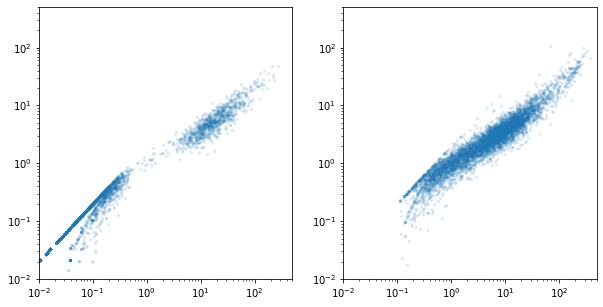

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax = axes[0]
exp_data_slice = exp_data[~exp_data['tzur_dynamic']]
ax.scatter(exp_data_slice['mean_exp'], exp_data_slice['mean_diff'], s=10, alpha=0.15, linewidth=0)

ax = axes[1]
exp_data_slice = exp_data[exp_data['tzur_dynamic']]
ax.scatter(exp_data_slice['mean_exp'], exp_data_slice['mean_diff'], s=10, alpha=0.15, linewidth=0)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([0.01,500])
    ax.set_ylim([0.01,500])

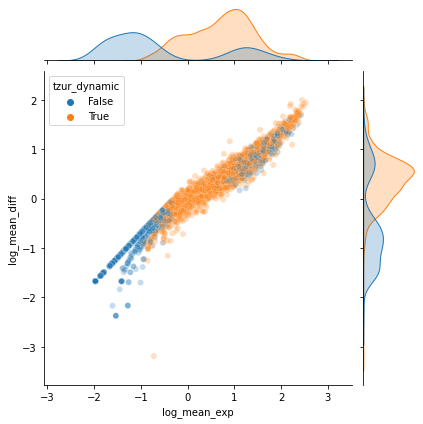

In [7]:
exp_data_slice = exp_data.dropna()
sns.jointplot(data=exp_data_slice, x='log_mean_exp', y='log_mean_diff', hue='tzur_dynamic', alpha=0.25)
plt.savefig('../img/231020_dynamic_joint_plot.png', dpi=200)

Try ANOVA? Expression is not normally distributed but might give a better idea about what we can confidently say varies

In [8]:
%%time
p_array = []
stat_array = []
for index, row in exp_data.iterrows():
    samples = []
    for num in range(1,11,1):
        samples.append([row['gonad_a'+str(num)], row['gonad_b'+str(num)]])
    stat, p = scipy.stats.f_oneway(*samples)
    p_array.append(p)
    stat_array.append(stat)
exp_data['p_anova'] = p_array
exp_data['stat_anova'] = stat_array

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\scipy\stats\_stats_py.py:3659: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


CPU times: total: 5.83 s
Wall time: 5.76 s


In [9]:
exp_data['p_anova'] = exp_data['p_anova'].fillna(1.0)

In [10]:
exp_data['q_anova'] = multitest.multipletests(exp_data['p_anova'], method='fdr_bh')[1]

In [12]:
exp_data['anova_dynamic'] = exp_data['q_anova'] < 0.01

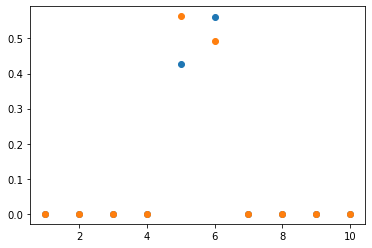

In [13]:
exp_data_slice = exp_data[exp_data['anova_dynamic'] & ~exp_data['tzur_dynamic']].sort_values('mean_exp')
plt.scatter(y=exp_data_slice[['gonad_a' + str(num) for num in range(1,11)]].tail(7).head(1), x=range(1,11))
plt.scatter(y=exp_data_slice[['gonad_b' + str(num) for num in range(1,11)]].tail(7).head(1), x=range(1,11))

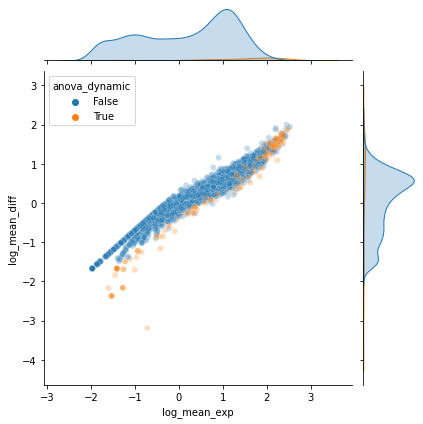

In [84]:
exp_data_slice = exp_data.dropna()
sns.jointplot(data=exp_data_slice, x='log_mean_exp', y='log_mean_diff', hue='anova_dynamic', alpha=0.25)
plt.savefig('../img/231020_anova_dynamic_joint_plot.png', dpi=200)

In [71]:
exp_data = exp_data.set_index('Open reading frame')

# Correlation plots

Using Tzur definition of dynamic

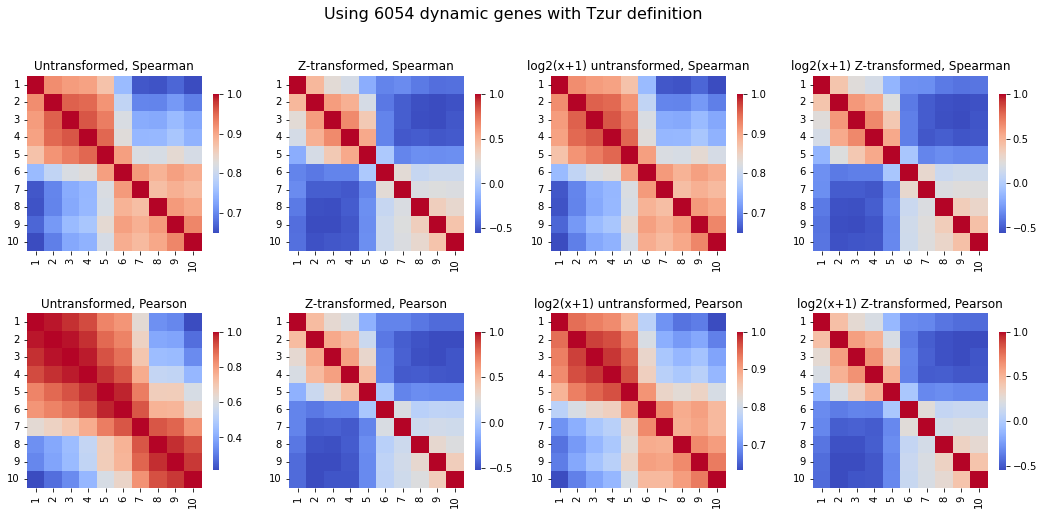

In [72]:
untransformed = exp_data[exp_data['dynamic_manual']][mean_columns]

fig, axes = plt.subplots(figsize=(18,8), nrows=2, ncols=4)

ax = axes[0,0]
sns.heatmap(untransformed.corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Untransformed, Spearman')

ax = axes[0,1]
sns.heatmap(scipy.stats.zscore(untransformed, axis=1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Z-transformed, Spearman')

ax = axes[1,0]
sns.heatmap(untransformed.corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Untransformed, Pearson')

ax = axes[1,1]
sns.heatmap(scipy.stats.zscore(untransformed, axis=1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Z-transformed, Pearson')

ax = axes[0,2]
sns.heatmap(np.log2(untransformed+1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) untransformed, Spearman')

ax = axes[0,3]
sns.heatmap(scipy.stats.zscore(np.log2(untransformed+1), axis=1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) Z-transformed, Spearman')

ax = axes[1,2]
sns.heatmap(np.log2(untransformed+1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) untransformed, Pearson')

ax = axes[1,3]
sns.heatmap(scipy.stats.zscore(np.log2(untransformed+1), axis=1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) Z-transformed, Pearson')

fig.suptitle('Using 6054 dynamic genes with Tzur definition', fontsize=16)

for ax in axes.flatten():
    xt = ax.set_xticks(ticks=np.arange(0.5,10.5,1), labels=range(1,11))
    yt = ax.set_yticks(ticks=np.arange(0.5,10.5,1), labels=range(1,11))
    
plt.savefig('../img/231020_correlation_tzur.png', dpi=200)

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


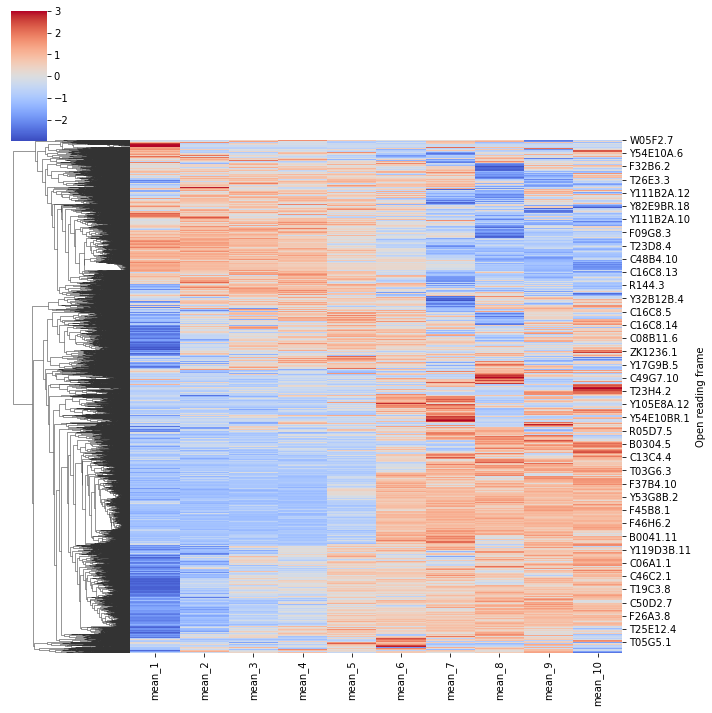

In [73]:
sns.clustermap(scipy.stats.zscore(np.log2(untransformed+1), axis=1), row_cluster=True, col_cluster=False, cmap='coolwarm')

Using ANOVA definition of dynamic

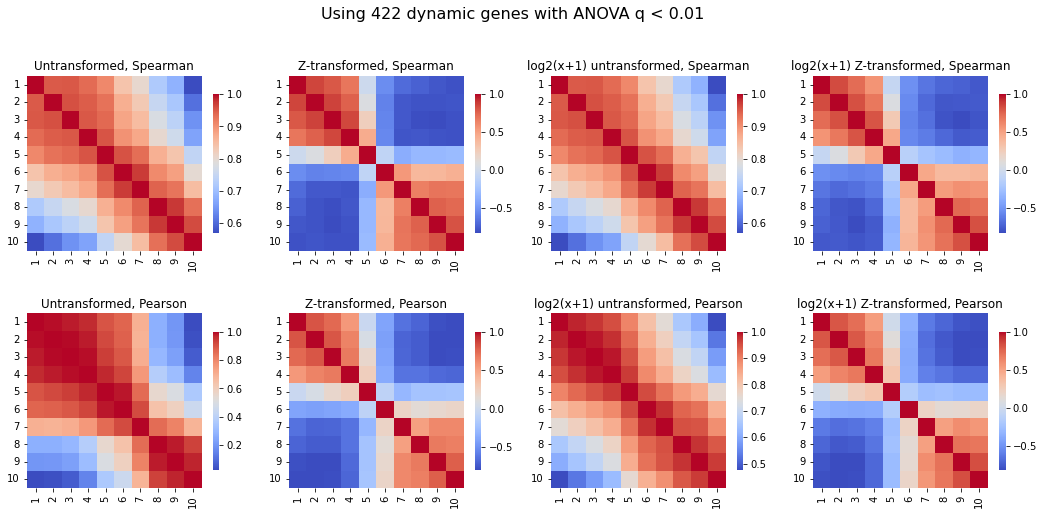

In [74]:
untransformed = exp_data[exp_data['q_anova'] < 0.01][mean_columns]

fig, axes = plt.subplots(figsize=(18,8), nrows=2, ncols=4)

ax = axes[0,0]
sns.heatmap(untransformed.corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Untransformed, Spearman')

ax = axes[0,1]
sns.heatmap(scipy.stats.zscore(untransformed, axis=1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Z-transformed, Spearman')

ax = axes[1,0]
sns.heatmap(untransformed.corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Untransformed, Pearson')

ax = axes[1,1]
sns.heatmap(scipy.stats.zscore(untransformed, axis=1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Z-transformed, Pearson')

ax = axes[0,2]
sns.heatmap(np.log2(untransformed+1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) untransformed, Spearman')

ax = axes[0,3]
sns.heatmap(scipy.stats.zscore(np.log2(untransformed+1), axis=1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) Z-transformed, Spearman')

ax = axes[1,2]
sns.heatmap(np.log2(untransformed+1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) untransformed, Pearson')

ax = axes[1,3]
sns.heatmap(scipy.stats.zscore(np.log2(untransformed+1), axis=1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) Z-transformed, Pearson')

fig.suptitle('Using ' + str(len(untransformed)) + ' dynamic genes with ANOVA q < 0.01', fontsize=16)

for ax in axes.flatten():
    xt = ax.set_xticks(ticks=np.arange(0.5,10.5,1), labels=range(1,11))
    yt = ax.set_yticks(ticks=np.arange(0.5,10.5,1), labels=range(1,11))
    
plt.savefig('../img/231020_correlation_anova.png', dpi=200)

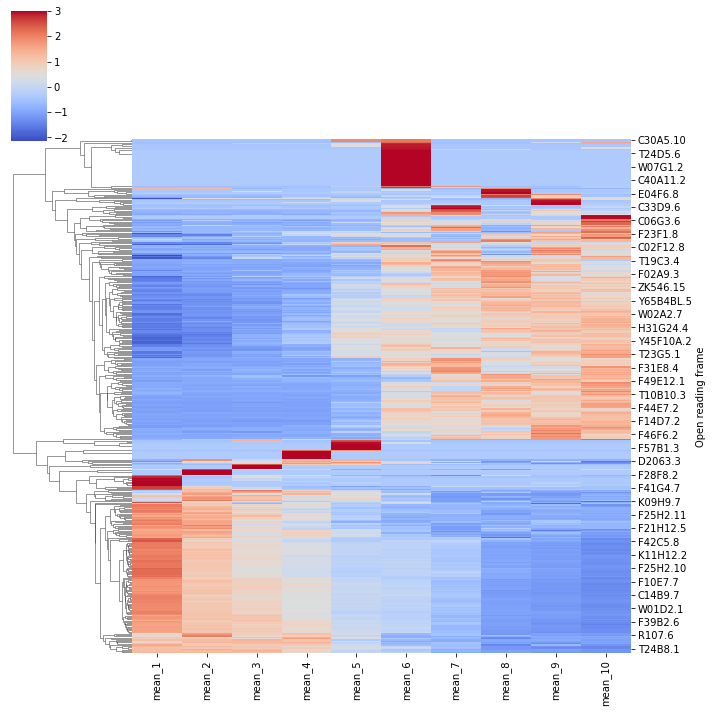

In [75]:
sns.clustermap(scipy.stats.zscore(untransformed, axis=1), row_cluster=True, col_cluster=False, cmap='coolwarm')

Using 25 "high confidence" genes (lowest ANOVA q and mean expression greater than 10)

In [77]:
highest_conf = exp_data[exp_data['mean_exp'] >= 10].sort_values('q_anova').head(25).index.values

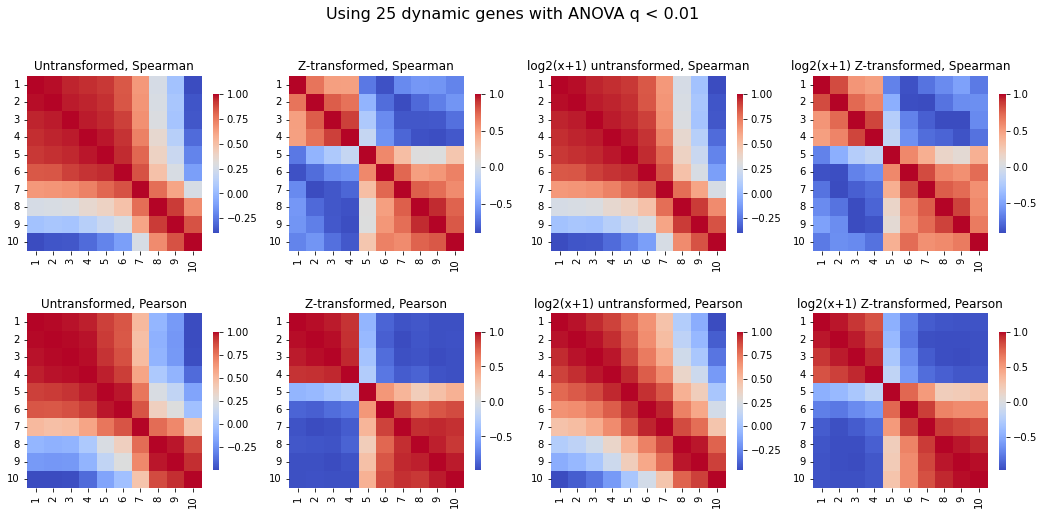

In [81]:
untransformed = exp_data[exp_data.index.isin(highest_conf)][mean_columns]

fig, axes = plt.subplots(figsize=(18,8), nrows=2, ncols=4)

ax = axes[0,0]
sns.heatmap(untransformed.corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Untransformed, Spearman')

ax = axes[0,1]
sns.heatmap(scipy.stats.zscore(untransformed, axis=1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Z-transformed, Spearman')

ax = axes[1,0]
sns.heatmap(untransformed.corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Untransformed, Pearson')

ax = axes[1,1]
sns.heatmap(scipy.stats.zscore(untransformed, axis=1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Z-transformed, Pearson')

ax = axes[0,2]
sns.heatmap(np.log2(untransformed+1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) untransformed, Spearman')

ax = axes[0,3]
sns.heatmap(scipy.stats.zscore(np.log2(untransformed+1), axis=1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) Z-transformed, Spearman')

ax = axes[1,2]
sns.heatmap(np.log2(untransformed+1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) untransformed, Pearson')

ax = axes[1,3]
sns.heatmap(scipy.stats.zscore(np.log2(untransformed+1), axis=1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) Z-transformed, Pearson')

fig.suptitle('Using ' + str(len(untransformed)) + ' dynamic genes with ANOVA q < 0.01', fontsize=16)

for ax in axes.flatten():
    xt = ax.set_xticks(ticks=np.arange(0.5,10.5,1), labels=range(1,11))
    yt = ax.set_yticks(ticks=np.arange(0.5,10.5,1), labels=range(1,11))
    
plt.savefig('../img/231020_correlation_highest_confidence.png', dpi=200)

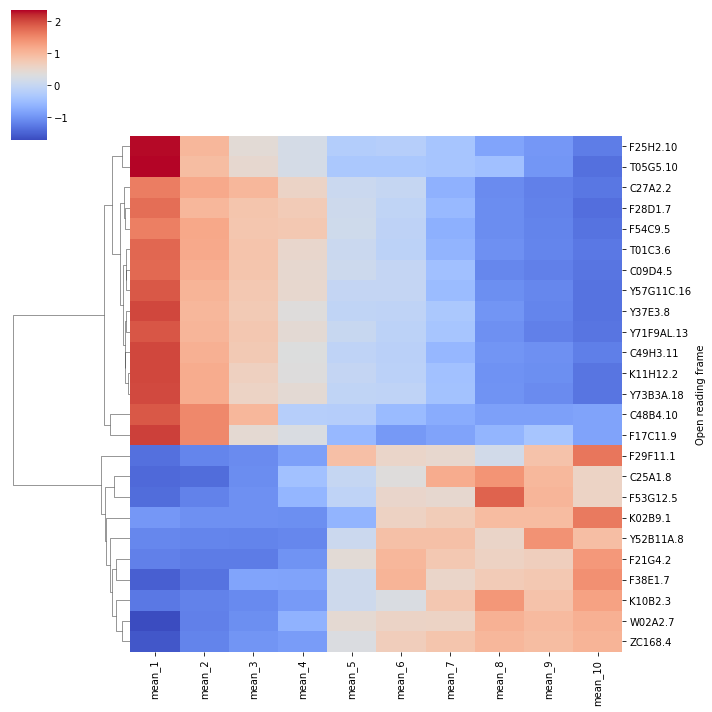

In [82]:
sns.clustermap(scipy.stats.zscore(untransformed, axis=1), row_cluster=True, col_cluster=False, cmap='coolwarm')

Using all genes

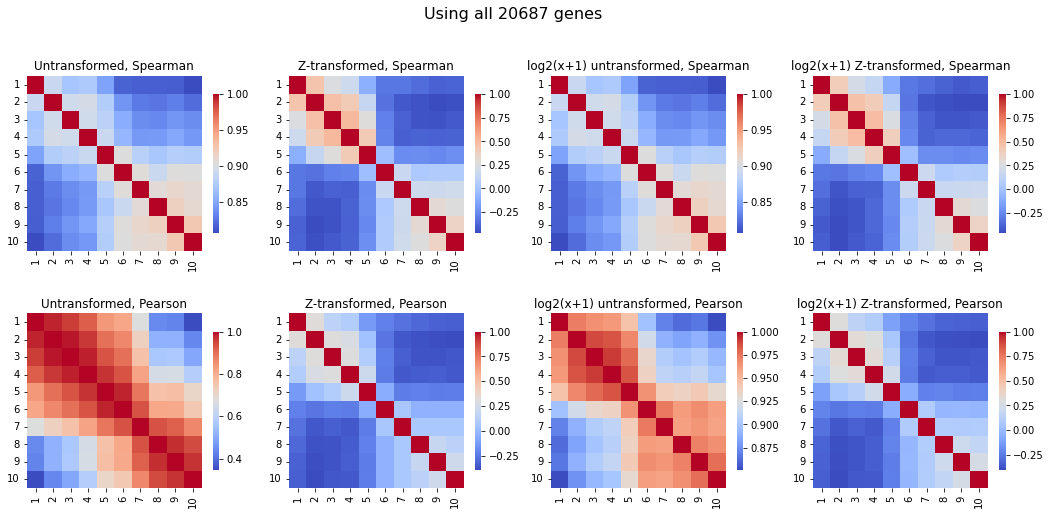

In [40]:
untransformed = exp_data[mean_columns]

fig, axes = plt.subplots(figsize=(18,8), nrows=2, ncols=4)

ax = axes[0,0]
sns.heatmap(untransformed.corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Untransformed, Spearman')

ax = axes[0,1]
sns.heatmap(scipy.stats.zscore(untransformed, axis=1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Z-transformed, Spearman')

ax = axes[1,0]
sns.heatmap(untransformed.corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Untransformed, Pearson')

ax = axes[1,1]
sns.heatmap(scipy.stats.zscore(untransformed, axis=1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('Z-transformed, Pearson')

ax = axes[0,2]
sns.heatmap(np.log2(untransformed+1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) untransformed, Spearman')

ax = axes[0,3]
sns.heatmap(scipy.stats.zscore(np.log2(untransformed+1), axis=1).corr('spearman'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) Z-transformed, Spearman')

ax = axes[1,2]
sns.heatmap(np.log2(untransformed+1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) untransformed, Pearson')

ax = axes[1,3]
sns.heatmap(scipy.stats.zscore(np.log2(untransformed+1), axis=1).corr('pearson'), cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink':0.7})
ax.set_title('log2(x+1) Z-transformed, Pearson')

fig.suptitle('Using all ' + str(len(untransformed)) + ' genes', fontsize=16)

for ax in axes.flatten():
    xt = ax.set_xticks(ticks=np.arange(0.5,10.5,1), labels=range(1,11))
    yt = ax.set_yticks(ticks=np.arange(0.5,10.5,1), labels=range(1,11))
    
plt.savefig('../img/231020_correlation_all.png', dpi=200)

In [103]:
for x in highest_conf:
    print(x)

Y52B11A.8
F29F11.1
C48B4.10
W02A2.7
K10B2.3
F28D1.7
C09D4.5
F53G12.5
Y57G11C.16
F17C11.9
F54C9.5
ZC168.4
C49H3.11
K11H12.2
Y71F9AL.13
F21G4.2
F25H2.10
F38E1.7
K02B9.1
Y37E3.8
T05G5.10
Y73B3A.18
T01C3.6
C27A2.2
C25A1.8


In [126]:
exp_data[exp_data['Gene Name'].astype(str).str.contains('rpl')].sort_values('q_anova')[['Gene Name', 'q_anova'] + list(mean_columns)]

,Gene Name,q_anova,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,mean_10
Open reading frame,,,,,,,,,,,,
C09D4.5,rpl-19,1.612e-04,332.316,266.499,234.929,198.411,157.959,147.325,102.822,33.482,27.000,14.671
F54C9.5,rpl-5,2.396e-04,269.210,234.942,201.781,199.188,140.890,120.915,71.886,37.969,28.936,15.116
Y71F9AL.13,rpl-1,2.412e-04,396.523,289.527,262.002,218.595,168.280,151.538,120.928,41.335,21.838,8.530
K11H12.2,rpl-15,2.412e-04,461.886,343.105,275.601,235.754,186.582,170.193,129.989,53.028,47.833,14.447
C27A2.2,rpl-22,2.719e-04,276.845,237.724,224.264,183.188,135.839,129.508,71.443,31.195,22.216,12.876
...,...,...,...,...,...,...,...,...,...,...,...,...
F54C4.1,mrpl-40,1.000e+00,9.273,10.036,7.764,11.591,10.903,7.882,15.714,6.213,9.495,7.108
T12G3.5,mrpl-51,1.000e+00,7.683,9.009,12.235,11.347,10.349,10.522,5.234,3.840,10.898,5.012
T25D3.2,mrpl-28,1.000e+00,8.145,13.778,8.250,8.379,9.674,8.304,4.283,7.205,5.716,4.940


In [116]:
for index in exp_data[exp_data['anova_dynamic']].index:
    print(index)

AH6.5
AH9.3
B0001.6
B0041.4
B0205.11
B0228.7
B0250.1
B0273.3
B0280.5
B0336.10
B0393.1
B0454.9
B0513.3
C01G5.2
C01G8.1
C02F12.8
C03A3.2
C03B1.12
C04E7.5
C04F12.1
C04F12.4
C05C10.5
C05C8.3
C05D11.8
C05D2.1
C05G5.3
C06B8.8
C06G3.5
C06G3.6
C06H2.7
C06H5.6
C07A12.4
C07D8.6
C08B11.1
C08F8.1
C09D4.5
C09F5.1
C09H10.2
C13A10.1
C13F10.4
C14A11.9
C14A4.1
C14B1.7
C14B9.7
C14F11.1
C14F11.4
C15H9.6
C16A11.3
C16A3.6
C16A3.9
C16C8.22
C17B7.11
C17G1.2
C23G10.3
C24A8.3
C25A1.10
C25A1.8
C25D7.6
C25H3.15
C26B9.1
C26C6.2
C26F1.4
C26F1.9
C27A2.2
C28D4.3
C30A5.10
C32B5.6
C32E8.2
C33D9.6
C33G3.3
C37A2.7
C38D4.1
C40A11.2
C41H7.3
C41H7.5
C42C1.14
C44B11.6
C44H4.7
C45E1.4
C46C2.2
C46C2.6
C48B4.10
C49H3.11
C50B6.2
C52A10.2
C53H9.1
C53H9.2
C54C6.1
C54H2.5
C55A6.6
D1007.12
D1007.6
D2030.5
D2063.3
D2096.8
DY3.8
E04A4.8
E04F6.8
F01F1.12
F01F1.15
F01G12.5
F02A9.3
F02H6.4
F07A11.2
F07A5.7
F08B6.4
F08F3.6
F08G2.3
F09E5.15
F10B5.1
F10E7.7
F11A5.18
F13B10.2
F13D11.3
F14B4.2
F14B6.1
F14D7.2
F14H3.6
F15D4.4
F16B12.6
F17A2.5